# Microbe Identification
# Scott Breitbach
## 30-June-2022

In [ ]:
## Load Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# plotting:
import matplotlib.pyplot as plt
import seaborn as sns
# transformations:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
# visualize correlation
from yellowbrick.features import Rank2D 
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Load data

In [ ]:
# import files to colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving microbes.csv to microbes.csv
User uploaded file "microbes.csv" with length 4274226 bytes


In [ ]:
def load_dataframe(path):
  # load dataset as pandas DataFrame
  DF = pd.read_csv(path, index_col=0)
  return DF

# load the dataframe
microbeDF = load_dataframe('/content/microbes.csv')

# Clean Data

### Remove duplicate column

In [ ]:
# remove 'ConvexHull2' (identical to 'ConvexHull1')
if microbeDF.ConvexHull1.equals(microbeDF.ConvexHull2):
  microbeDF = microbeDF.drop('ConvexHull2', axis=1)

### Look at summary stats

In [ ]:
# get a look at the data
microbeDF.describe().T

,count,mean,std,min,25%,50%,75%,max
Solidity,30527.0,9.677744,4.063437,0.0,6.5700,9.3500,12.6000,23.0
Eccentricity,30527.0,19.466921,3.479828,0.0,17.3000,20.7000,22.2000,23.0
EquivDiameter,30527.0,3.633348,2.210851,0.0,2.1800,3.3800,4.5800,23.0
Extrema,30527.0,11.871832,6.045135,0.0,6.7900,12.0000,17.2000,23.0
FilledArea,30527.0,0.420022,0.875091,0.0,0.0937,0.2290,0.4345,23.0
Extent,30527.0,5.840625,3.250999,0.0,3.2800,5.2600,7.8500,23.0
Orientation,30527.0,11.751004,6.575319,0.0,6.0050,12.1000,17.2000,23.0
EulerNumber,30527.0,22.380901,0.962906,0.0,22.3000,22.6000,22.9000,23.0
BoundingBox1,30527.0,10.919027,6.093280,0.0,5.6900,10.9000,15.8000,23.0
BoundingBox2,30527.0,10.399429,5.797144,0.0,5.7300,10.0000,14.9000,23.0


### Look at data distribution

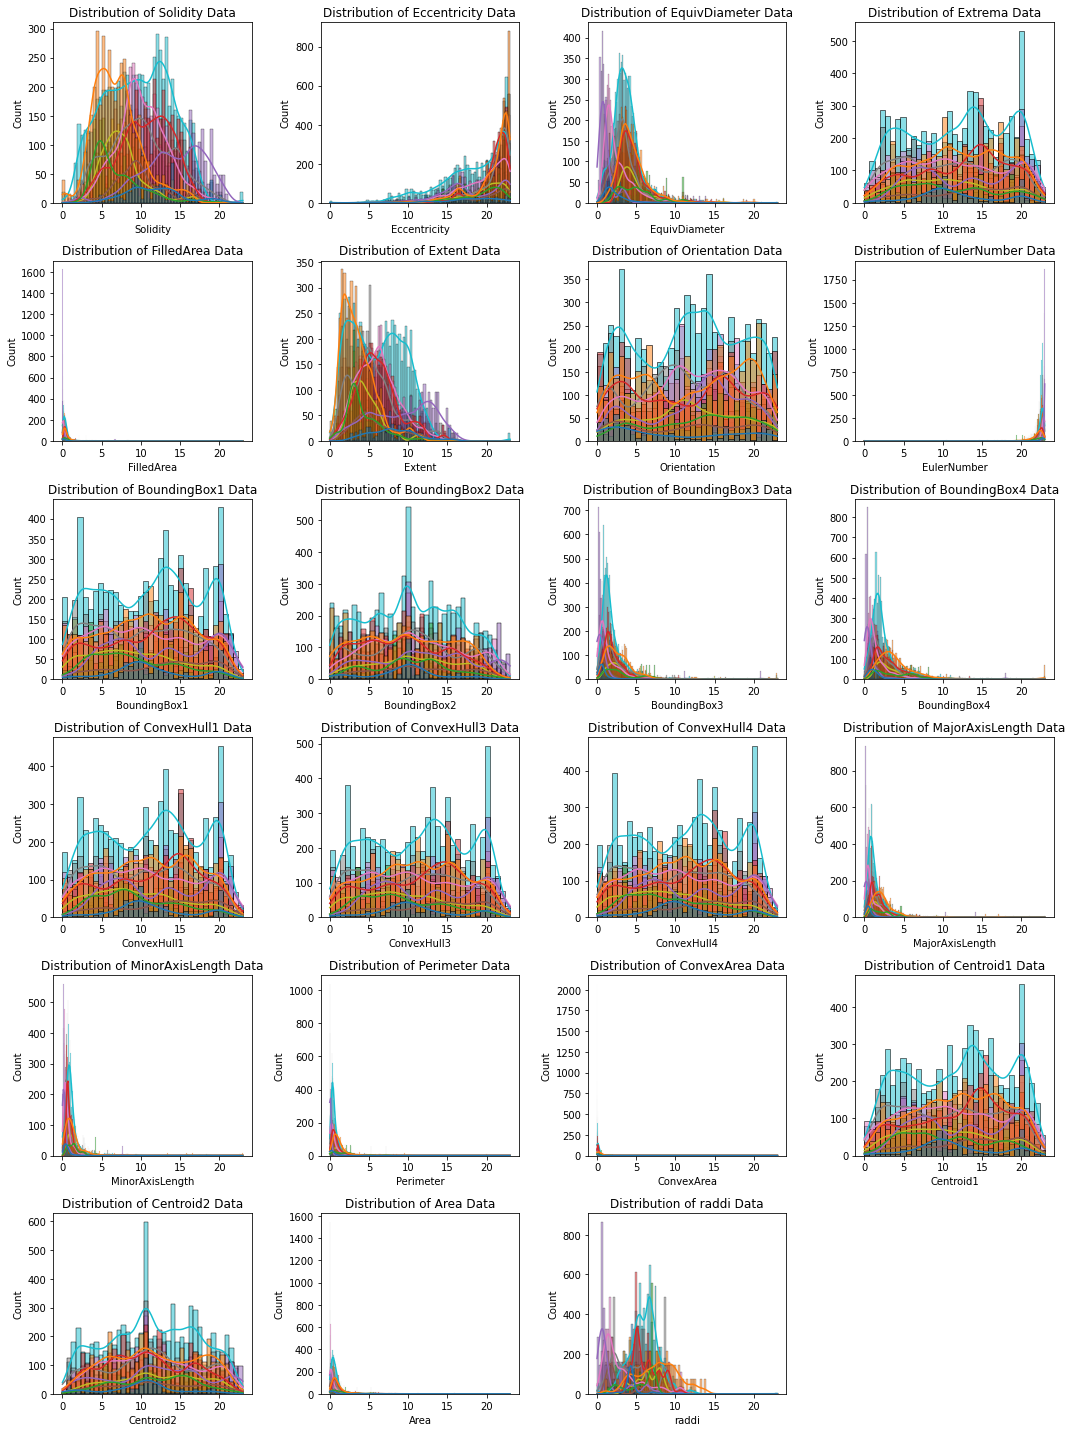

CPU times: user 3min 35s, sys: 5.85 s, total: 3min 41s
Wall time: 3min 45s


In [ ]:
%%time
# Look at histograms by variable
plt.figure(figsize=(15, 20))
for i, col in enumerate(microbeDF.columns[:-1], 1):
  plt.subplot(6, 4, i)
  plt.title(f'Distribution of {col} Data')
  sns.histplot(data=microbeDF, x=col, kde=True, hue='microorganisms', legend=False)
  plt.tight_layout()
  plt.plot()
plt.show()

Histograms show a lot of skewed variables as well as strong similarities between some variables.

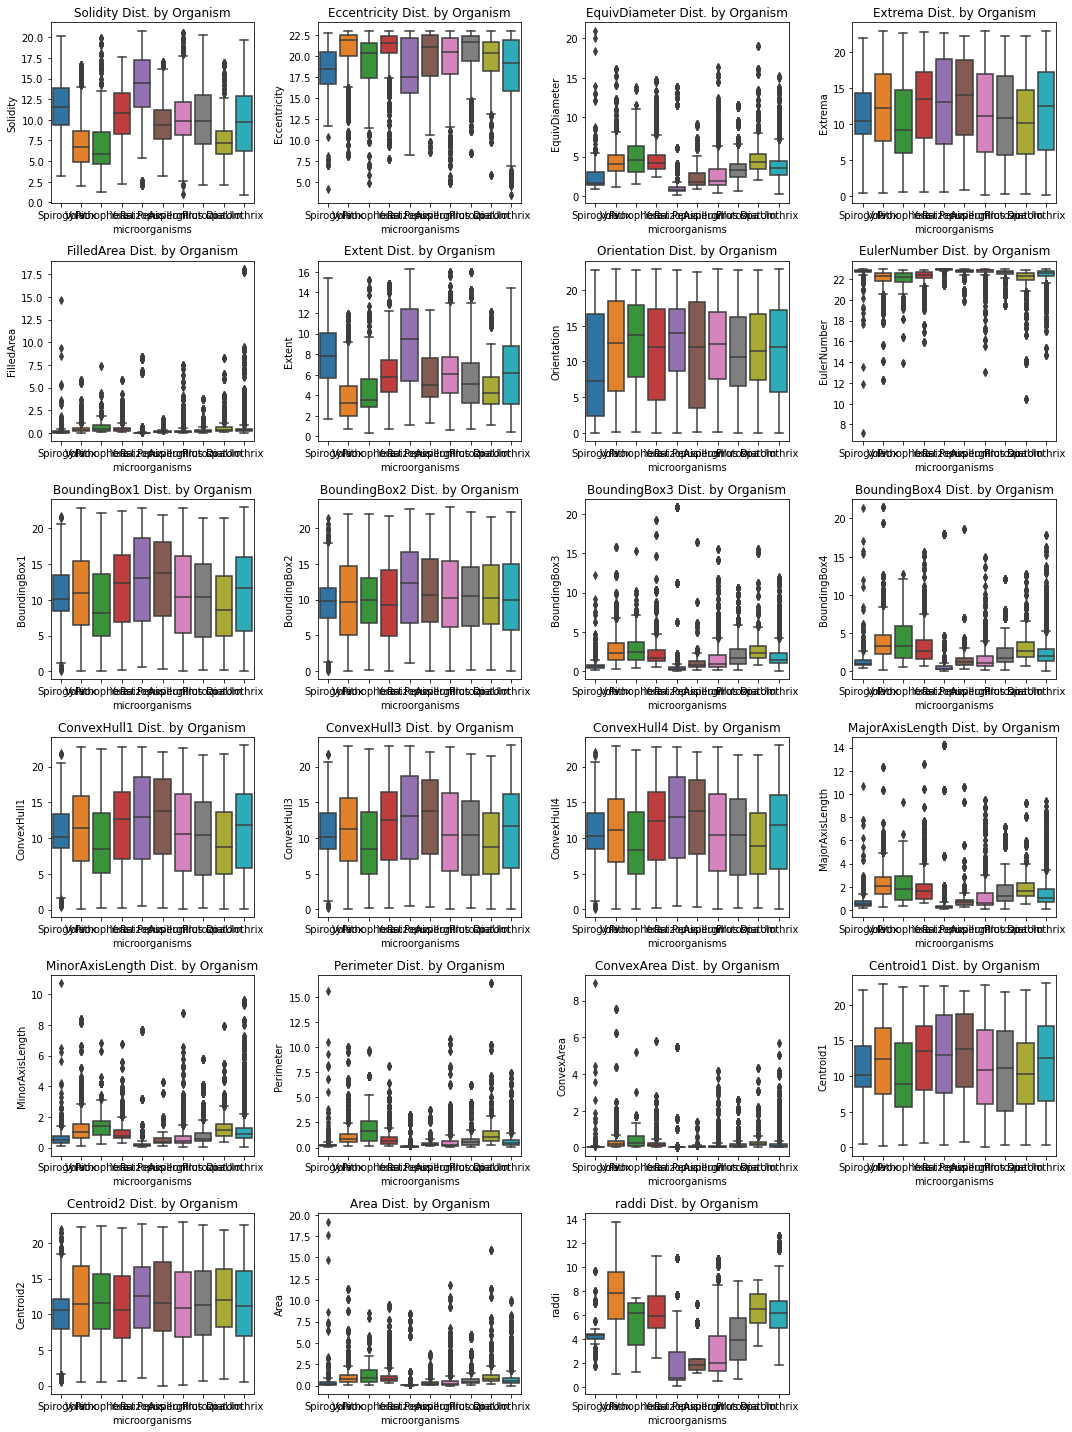

CPU times: user 12.6 s, sys: 273 ms, total: 12.9 s
Wall time: 13.3 s


In [ ]:
%%time
# Look at box plots by variable
plt.figure(figsize=(15, 20))
for i, col in enumerate(microbeDF.columns[:-1], 1):
  plt.subplot(6, 4, i)
  plt.title(f'{col} Dist. by Organism')
  sns.boxplot(y=microbeDF[col], x=microbeDF['microorganisms'])
  plt.tight_layout()
  plt.plot()
plt.show()

Lots of data points at the extremes (0 and 23). These values don't make sense for a lot of the variables and are likely outliers and should be removed.

### Remove 0s and 23s from select variables

In [ ]:
def remove_zeros(df):
  '''drops rows containing '0' from a specified column'''
  # columns from which to remove zeros
  noZeros = ['Solidity', 'Eccentricity', 'EquivDiameter', 
           'FilledArea', 'Extent', 'EulerNumber', 
           'BoundingBox4', 'BoundingBox4', 'BoundingBox4', 'BoundingBox4',
           'ConvexHull1', 'ConvexHull3', 'ConvexHull4',
           'MajorAxisLength', 'MinorAxisLength', 'Perimeter', 
           'ConvexArea','raddi', 'Area']
  # Remove rows w/0s from specified columns
  for i in noZeros:
    df = df[df[i] != 0]
  return df

def remove_23s(df):
  '''drops rows containing '23' from a specified column'''
  # columns from which to remove 23s
  remove23s = ['Solidity', 'EquivDiameter', 'FilledArea', 'Extent', 
             'BoundingBox3', 'BoundingBox4', 'MajorAxisLength', 
             'MinorAxisLength', 'Perimeter', 'ConvexArea', 'raddi', 'Area']
  # Remove rows w/0s from specified columns
  for i in remove23s:
    df = df[df[i] != 23]
  return df

# drop rows containing 0 from specified columns
microbeDF = remove_zeros(microbeDF)
# drop rows containing 23 from specified columns
microbeDF = remove_23s(microbeDF)  

### Split data into features (X)/target (y) and train/test sets

In [ ]:
def load_dataset(DF):
  # retrieve numpy array
  dataset = DF.values
  # split into input (X) and output (y) variables
  X, y = dataset[:, :-1], dataset[:,-1]
  # ensure inputs are floats and output is an integer label
  X = X.astype('float32')
  return X, y

# load the dataset
X, y = load_dataset(microbeDF)

# split into train and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1) # making test set 1/3 of data

# summarize
print('Train:', X_train_raw.shape, y_train.shape)
print('Test: ', X_test_raw.shape, y_test.shape)

Train: (20311, 23) (20311,)
Test:  (10004, 23) (10004,)


### Fix skew in data using Box-Cox transformation

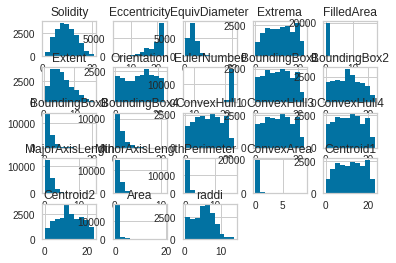

In [ ]:
# Look at distributions pre-transformation
dataset = pd.DataFrame(X_train_raw, columns=microbeDF.columns[:-1])
dataset.hist()
plt.show()

In [ ]:
## Transform features:

# define the pipeline
scaler = MinMaxScaler(feature_range=(1, 2)) # data must be >0 for Box-Cox
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])

# data = pipeline.fit_transform(data)
X_train = pipeline.fit_transform(X_train_raw)
X_test = pipeline.transform(X_test_raw)

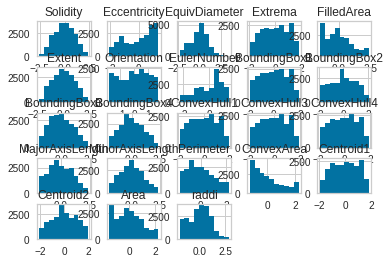

In [ ]:
# Look at distributions post-transformation
dataset = pd.DataFrame(X_train, columns=microbeDF.columns[:-1])
dataset.hist()
plt.show()

### Rebalance training data using oversampling / undersampling

In [ ]:
# ## Balance class distribution
# from collections import Counter
# # summarize class distribution
# print(Counter(y_train))
# # get an average class size
# balancedNum = int(round(len(y_train)/10, 0))
# balancedNum
# # set up dictionary of classes to resample (< average number of samples)
# resampleDict = {}
# for i in np.unique(y_train):
#   if Counter(y_train)[i] < balancedNum:
#     resampleDict[i] = balancedNum

# ## Oversampling
# from imblearn.over_sampling import RandomOverSampler
# # define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy=resampleDict)
# # fit and apply the transform
# X_over, y_over = oversample.fit_resample(X_train, y_train)
# # summarize class distribution
# print(Counter(y_over))

# ## Undersampling
# from imblearn.under_sampling import RandomUnderSampler
# # define oversampling strategy
# undersample = RandomUnderSampler(sampling_strategy='auto')
# # fit and apply the transform
# # X_under, y_under = undersample.fit_resample(X_over, y_over)
# X_train, y_train = undersample.fit_resample(X_over, y_over)
# # summarize class distribution
# # print(Counter(y_under))
# print(Counter(y_train))

### Look for correlations

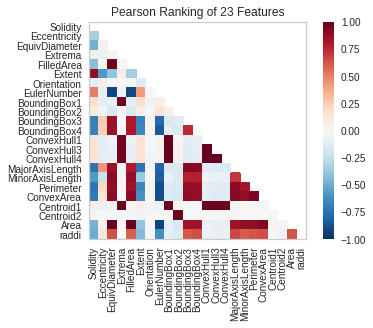

In [ ]:
## Pearson ranking
# extract the feature names from the DataFrame
num_features = microbeDF.columns[:-1]
# combine transformed train & test sets
data = np.concatenate((X_train, X_test), axis=0)

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(data)  # Fit the data to the visualizer
visualizer.transform(data)  # Transform the data
visualizer.poof() # Draw/show/poof the data

Several groups of features appear to be highly correlated, such as:  
* 'Area' with 'EquivDiameter' and 'FilledArea' and to a lesser extent: 
 * 'BoundingBox3', 'BoundingBox4', 'MajorAxisLength', 'MinorAxisLength', 'Perimeter', and 'ConvexArea' 
 * 'EulerNumber' appears to have a relatively strong negative correlation with this group
* 'Extrema' with 'BoundingBox1', 'ConvexHull1', 'ConvexHull3', 'ConvexHull4', and 'Centroid1'
* 'Centroid2' with 'BoundingBox2'

### [Feature Selection with Numerical Input Data](https://machinelearningmastery.com/feature-selection-with-numerical-input-data/)

Feature 0: 543.0287475585938 - Solidity
Feature 1: 220.66995239257812 - Eccentricity
Feature 2: 1150.9696044921875 - EquivDiameter
Feature 3: 28.058277130126953 - Extrema
Feature 4: 822.8834838867188 - FilledArea
Feature 5: 420.1198425292969 - Extent
Feature 6: 21.27373695373535 - Orientation
Feature 7: 995.3804321289062 - EulerNumber
Feature 8: 46.636558532714844 - BoundingBox1
Feature 9: 29.911985397338867 - BoundingBox2
Feature 10: 828.2567138671875 - BoundingBox3
Feature 11: 1058.40185546875 - BoundingBox4
Feature 12: 42.558223724365234 - ConvexHull1
Feature 13: 45.476341247558594 - ConvexHull3
Feature 14: 44.93679428100586 - ConvexHull4
Feature 15: 940.14599609375 - MajorAxisLength
Feature 16: 869.3492431640625 - MinorAxisLength
Feature 17: 1044.966064453125 - Perimeter
Feature 18: 719.1508178710938 - ConvexArea
Feature 19: 28.700681686401367 - Centroid1
Feature 20: 12.054688453674316 - Centroid2
Feature 21: 913.4406127929688 - Area
Feature 22: 1513.4505615234375 - raddi


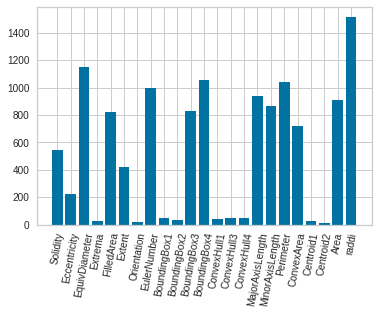

In [ ]:
## Feature selection using ANOVA f-test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
 
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print(f'Feature {i}: {fs.scores_[i]} - {microbeDF.columns[i]}')
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_, 
        tick_label=microbeDF.columns[:-1])
plt.xticks(rotation = 80)
plt.show()

Accuracy using all 23 features:

In [ ]:
## Feature selection using ANOVA f-test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
 
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 49.96


Accuracy using top 14 features:

In [ ]:
## Feature selection using ANOVA f-test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
 
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k=14)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 48.36


In [ ]:
%%time
# compare different numbers of features selected using anova f-test
from pandas import read_csv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
 
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LogisticRegression(solver='liblinear')
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
# define the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

Best Mean Accuracy: 0.471
Best Config: {'anova__k': 23}
CPU times: user 19 s, sys: 1.24 s, total: 20.3 s
Wall time: 23min 21s


ANOVA indicates 23 features is best.  
Note: this is not the transformed data.

>1 0.373 (0.006)
>2 0.359 (0.005)
>3 0.348 (0.006)
>4 0.385 (0.008)
>5 0.389 (0.007)
>6 0.407 (0.007)
>7 0.421 (0.006)
>8 0.431 (0.007)
>9 0.441 (0.008)
>10 0.441 (0.008)
>11 0.444 (0.007)
>12 0.460 (0.006)
>13 0.462 (0.007)
>14 0.462 (0.007)
>15 0.461 (0.006)
>16 0.461 (0.006)
>17 0.462 (0.006)
>18 0.462 (0.006)
>19 0.465 (0.005)
>20 0.467 (0.007)
>21 0.471 (0.007)
>22 0.469 (0.007)
>23 0.471 (0.007)


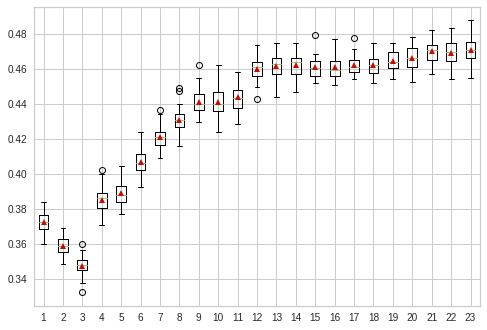

CPU times: user 14 s, sys: 1.15 s, total: 15.2 s
Wall time: 22min 17s


In [ ]:
%%time
# compare different numbers of features selected using anova f-test
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# # define dataset
# X, y = load_dataset('pima-indians-diabetes.csv')
# define number of features to evaluate
num_features = [i+1 for i in range(X.shape[1])]
# enumerate each number of features
results = list()
for k in num_features:
	# create pipeline
	model = LogisticRegression(solver='liblinear')
	fs = SelectKBest(score_func=f_classif, k=k)
	pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
	# evaluate the model
	scores = evaluate_model(pipeline, X, y)
	results.append(scores)
	# summarize the results
	print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

Best results with including all features. Possibly this could be improved with class balancing (either through initial sampling/resampling or setting to balanced weights in the model) or by using the transformed data.

# Modeling

## Set up model evaluation

In [ ]:
# Set up DataFrame to store comparisons
model_compare = pd.DataFrame()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def get_model_metrics(name, model):
  '''Prints confusion matrix and some metrics; returns metrics in a DF'''
  cols = ['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall']
    # get predictions
  predictions = model.predict(X_test)
  
  # print confusion matrix
  cm = confusion_matrix(y_test, predictions)
  print(cm)
  
  # get accuracy, f1-score, precision, and recall
  accuracy = round(model.score(X_test, y_test)*100, 2)
  print('Accuracy: ', accuracy)
  cr = classification_report(y_test, predictions, output_dict=True)
  f1Score = round(cr['weighted avg']['f1-score'], 4)
  print('F1-Score: ', f1Score)
  precision = round(cr['weighted avg']['precision'], 4)
  print('Precision:', precision)
  recall = round(cr['weighted avg']['recall'], 4)
  print('Recall:   ', recall)

  df = pd.DataFrame([[name, accuracy, f1Score, precision, recall]],
                    columns=cols)
  return df

## Random Forest

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import RandomForestClassifier

# Create classifier
rfClass = RandomForestClassifier(class_weight='balanced')

# Train model
rfClass.fit(X_train, y_train)

CPU times: user 5.41 s, sys: 19.9 ms, total: 5.43 s
Wall time: 5.45 s


In [ ]:
# Evaluate model
tempDF = get_model_metrics('RandomForest', rfClass)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[1241    4    0    4    2    0    0   18   10   10]
 [   0  545    0    0    0    0    0    6    0    0]
 [   0    0  365    0    0    0    0    0    0    0]
 [   2   10    0  417    6    0    0   26    2    0]
 [   0    0    0    0 1259    0    0    0    0    0]
 [   0    0    0    0    0  864    0    0    0    0]
 [   4    6    0    4    0    0  165   26    0    9]
 [  12    6    2    4    0    0    0 2358    8    2]
 [   0    0    0    0    0    0    0    0 1439    0]
 [   0    0    0    0    0    0    0    0    0 1168]]
Accuracy:  98.17
F1-Score:  0.9813
Precision: 0.9819
Recall:    0.9817


## Decision Tree

In [ ]:
%%time
# Load libraries
from sklearn.tree import DecisionTreeClassifier

# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(class_weight='balanced')

# Train model
decisiontree.fit(X_train, y_train)

CPU times: user 475 ms, sys: 4.98 ms, total: 480 ms
Wall time: 479 ms


In [ ]:
# Evaluate model
tempDF = get_model_metrics('DecisionTree', decisiontree)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[1249    6    0    4    2    0    4   10    4   10]
 [   0  545    0    0    0    0    0    0    6    0]
 [   0    0  365    0    0    0    0    0    0    0]
 [   8    2    0  421    8    2    4   14    4    0]
 [   0    0    0    0 1259    0    0    0    0    0]
 [   0    0    0    0    0  864    0    0    0    0]
 [  13    4    0    3    1    0  168   18    1    6]
 [  12    4    2    8   10    0    2 2332   12   10]
 [   0    0    0    0    0    0    0    0 1439    0]
 [   0    0    0    0    4    0    4    0    0 1160]]
Accuracy:  97.98
F1-Score:  0.9795
Precision: 0.9796
Recall:    0.9798


## Logistic Regression

In [ ]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           max_iter=1000)

# Train model
logit.fit(X_train, y_train)

CPU times: user 16.6 s, sys: 10.4 s, total: 27 s
Wall time: 18 s


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LogReg', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[298  56 325  37 189 151  75  35  67  56]
 [ 15 230   9 122  14   0  32  36  64  29]
 [ 27  16 221   9  22  13  31  15   9   2]
 [ 16  32  41 323   9   0  21  10   4   7]
 [107 100 106  48 487  62  63  52  92 142]
 [ 19   3  70   0   7 694  46  22   0   3]
 [  5   6   3  13   2   0 159  15   1  10]
 [ 72 196 121  89 114  77 289 740 376 318]
 [ 12 145  70  97  66   0  43  84 774 148]
 [ 10  68   3   8  77   1  50  92 163 696]]
Accuracy:  46.2
F1-Score:  0.4604
Precision: 0.5258
Recall:    0.462


## Gaussian Naive Bayes Classifier

In [ ]:
%%time
# Load libraries
from sklearn.naive_bayes import GaussianNB

# Create Gaussian naive Bayes object
nBayes = GaussianNB()

# Fit model
nBayes.fit(X_train, y_train)

CPU times: user 60.8 ms, sys: 0 ns, total: 60.8 ms
Wall time: 65.9 ms


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GaussianNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[102  75 186  78  92 538  47  26  90  55]
 [  1 207  11  92  45   4   9  71  69  42]
 [ 28   3 139  13  35 117   6  17   7   0]
 [ 28  88  37 150  34   8  24  45  39  10]
 [ 87 109 175  68 237 195  46  50 221  71]
 [  0   0  74  25  15 708   9  27   6   0]
 [  7   7   9   9   6  52 109   9   1   5]
 [ 94 183 194 193 161 211 186 619 309 242]
 [ 26 152  75 111  95  23  34 109 689 125]
 [  0 115  50 112  68   0 153 162 170 338]]
Accuracy:  32.97
F1-Score:  0.3166
Precision: 0.3722
Recall:    0.3297


## Support Vector Classifier (SVC)

In [ ]:
%%time
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(class_weight='balanced')

# Fit model
svc.fit(X_train, y_train)

CPU times: user 42.9 s, sys: 282 ms, total: 43.2 s
Wall time: 47.5 s


In [ ]:
# Evaluate model
tempDF = get_model_metrics('SVC', svc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[ 652   89  227   19   92   60   27   33   61   29]
 [   4  431    1   48   13    0    8   20   13   13]
 [  30    0  323    2    6    2    0    2    0    0]
 [  19   49   21  343    8    0    5   15    2    1]
 [  91   99   62    6  857   15   10   47   54   18]
 [   7   17   52    0    0  772    9    7    0    0]
 [   1    9    3    9    5    0  165   15    2    5]
 [  98  214  105  103   94   23   64 1251  229  211]
 [  21  183   65   55   46    0   13   52  950   54]
 [   2   91    2    9   29    0   12   74   61  888]]
Accuracy:  66.29
F1-Score:  0.6695
Precision: 0.7148
Recall:    0.6629


## Linear SVC

In [ ]:
%%time
# Load libraries
from sklearn.svm import LinearSVC

# Create classification model
linSVC = LinearSVC(class_weight='balanced')

# Fit model
linSVC.fit(X_train, y_train)

CPU times: user 42.8 s, sys: 29.1 ms, total: 42.9 s
Wall time: 42.8 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
# Evaluate model
tempDF = get_model_metrics('LinearSVC', linSVC)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[218  34 309  61 170 219 101  37  78  62]
 [ 11 176  17 168  14   0  26  54  63  22]
 [ 17   2 193  11  12  35  59  11  23   2]
 [ 11  17  35 341   7   0  22  16   7   7]
 [ 39  86 124  75 379 115  68  68 107 198]
 [  7   0  59   0   7 742  23  26   0   0]
 [  4   4   4  17   0  10 149  17   0   9]
 [ 56 115 117 135  89  90 258 866 394 272]
 [  9 103  73 112  54   2  36 115 782 153]
 [  4  44   3  23  58   2  58 123 148 705]]
Accuracy:  45.49
F1-Score:  0.4472
Precision: 0.5159
Recall:    0.4549


## Ada Boost Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Create classifier
adaboost = AdaBoostClassifier()

# Train model
adaboost.fit(X_train, y_train)

CPU times: user 3.92 s, sys: 14.7 ms, total: 3.94 s
Wall time: 3.94 s


In [ ]:
# Evaluate model
tempDF = get_model_metrics('AdaBoost', adaboost)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[ 99  12 191   4 106 613  11  85  36 132]
 [  6   6  20  20  48   0   2 148  41 260]
 [  9  19 120   0   0 195   4   3   2  13]
 [ 17   6  81  15  18  15   1  90  28 192]
 [ 27   5 207  14 218 292   0 133  29 334]
 [ 12   0  40   0   0 649   0 159   4   0]
 [ 78   9   6   3  10   4  49  43   6   6]
 [232 144 110  45 102  68  17 960 130 584]
 [ 41  29  79  13  69  41   1 181 264 721]
 [  0  21  16  15 102  26   0 303  40 645]]
Accuracy:  30.24
F1-Score:  0.2771
Precision: 0.3194
Recall:    0.3024


## MLP Classifier

In [ ]:
%%time
# Load libraries
from sklearn.neural_network import MLPClassifier

# Create classification model
mlp = MLPClassifier(early_stopping=True)

# Fit model
mlp.fit(X_train, y_train)

CPU times: user 22.8 s, sys: 18.2 s, total: 41 s
Wall time: 22.5 s


In [ ]:
# Evaluate model
tempDF = get_model_metrics('MLP', mlp)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[ 823   34   32    5  104   56    6   84   99   46]
 [   0  310    0   25   30    0    0  110   44   32]
 [  93    5  190    0   22   14    0   32    9    0]
 [  18   36    4  307   22    0    2   46   22    6]
 [  82   22    0    0 1033   13    0   28   48   33]
 [  23    0    0    0    1  808    0   32    0    0]
 [   6    3    2    5    4    1  137   47    4    5]
 [  74   67   23   38   76    8   10 1802  185  109]
 [  21   45   22   13   36    4    0  184 1056   58]
 [   5   18    0    0   29    0    1   97   70  948]]
Accuracy:  74.11
F1-Score:  0.7392
Precision: 0.7409
Recall:    0.7411


## Gradient Boosting Classifier

In [ ]:
%%time
# Load libraries
from sklearn.ensemble import GradientBoostingClassifier

# Create classification model
gbc = GradientBoostingClassifier()

# Fit model
gbc.fit(X_train, y_train)

CPU times: user 1min 45s, sys: 175 ms, total: 1min 46s
Wall time: 1min 45s


In [ ]:
# Evaluate model
tempDF = get_model_metrics('GBC', gbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

[[1020   32    4    5   29    5    3  115   52   24]
 [   0  446    0    0    5    0    0   64   31    5]
 [   0    0  365    0    0    0    0    0    0    0]
 [  22   18    2  330   15    0    2   65    3    6]
 [   0    0    0    0 1241    0    0   18    0    0]
 [   0    0    0    0    0  854    0   10    0    0]
 [   7    3    0    2    5    0  178   14    2    3]
 [  72   33    6    3   54    4    8 2076   96   40]
 [  20    9    0    0   17    0    3  122 1215   53]
 [   2   15    0    0    9    0    0   79   37 1026]]
Accuracy:  87.48
F1-Score:  0.874
Precision: 0.877
Recall:    0.8748


## Model Comparisons

In [ ]:
# Compare model metrics
model_compare.sort_values('Accuracy', ascending=False)

,Model,Accuracy,F1_Score,Precision,Recall
0,RandomForest,98.17,0.9813,0.9819,0.9817
1,DecisionTree,97.98,0.9795,0.9796,0.9798
8,GBC,87.48,0.8740,0.8770,0.8748
7,MLP,74.11,0.7392,0.7409,0.7411
4,SVC,66.29,0.6695,0.7148,0.6629
2,LogReg,46.20,0.4604,0.5258,0.4620
5,LinearSVC,45.49,0.4472,0.5159,0.4549
3,GaussianNB,32.97,0.3166,0.3722,0.3297
6,AdaBoost,30.24,0.2771,0.3194,0.3024


# Hyperparameter Tuning

### Random Forest Classifier

In [ ]:
# Load libraries
from sklearn.model_selection import GridSearchCV

# Create classifier
rfc = RandomForestClassifier(random_state=42,
                             class_weight='balanced')

# Get a baseline model
baseline = rfc.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'n_estimators': [30, 100, 300, 1000], 
    'criterion': ['gini', 'entropy'], 
    'max_features': ['sqrt', 'log2', None], 
}
grid = GridSearchCV(rfc, parameter_space, cv=5)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 11min 28s, sys: 5.08 s, total: 11min 33s
Wall time: 1h 27min 56s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'criterion': 'entropy', 'max_features': None, 'n_estimators': 1000} 

Baseline Accuracy:	98.18
Tuned Accuracy:		98.72


### Decision Tree Classifier

In [ ]:
# Load libraries
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(random_state=42, 
                                      class_weight='balanced')

# Get a baseline model
baseline = decisiontree.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0, 0.1, 0.01, 0.001]
}
grid = GridSearchCV(decisiontree, parameter_space, cv=5)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9000 fits failed out of a total of 27000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_fail

CPU times: user 35min 40s, sys: 6.02 s, total: 35min 46s
Wall time: 35min 44s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'} 

Baseline Accuracy:	98.0
Tuned Accuracy:		98.67


Fine tune a bit:

In [ ]:
# Load libraries
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(random_state=42, 
                                      class_weight='balanced')

# Get a baseline model
baseline = decisiontree.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'criterion': ['entropy'], 
    'splitter': ['best'],
    'max_depth': [None, 1, 10],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': [None],
    'ccp_alpha': [0]
}
grid = GridSearchCV(decisiontree, parameter_space, cv=5)

In [ ]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 254, in fit
    % self.min_samples_split
ValueError: min_samples_split must be an integer greater than 1 or a float i

CPU times: user 25.2 s, sys: 65.7 ms, total: 25.3 s
Wall time: 26.5 s


In [ ]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'} 

Baseline Accuracy:	98.0
Tuned Accuracy:		98.67


Same result 👍